In [1]:
import numpy as np
import matplotlib.pyplot as plt
import model_list, models, fitting
import corner
import copy as cp

from utils import rj2cmb

In [2]:
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
nu_pico = np.asarray([21,25,30, 36.0,43.2,51.8,62.2,74.6,89.6,
                      107.5,129.0,154.8,185.8,222.9,267.5,321.0,
                      385.2,462.2,554.7,665.6,798.7]) * 1e9

In [4]:
mean_beta = 1.6
mean_temp = 20.
sigma_beta = .2
sigma_temp = 4.

DUST_I = 50.
DUST_P = 5. / 1.41
amp_I=rj2cmb(353e9, DUST_I)
amp_Q=rj2cmb(353e9, DUST_P)
amp_U=rj2cmb(353e9, DUST_P)

In [5]:
sMBB = model_list.dust_model
TMFM = model_list.TMFM
cmb = model_list.cmb_model
sync = model_list.sync_model

In [6]:
models_sMBB = [sMBB, cmb, sync]
models_TMFM = [TMFM, cmb, sync]

In [7]:
def make_pnames(models_fit):
    amp_names = []
    param_names = []

    for mod in models_fit:
        # Parameter names
        amp_names += ["%s_%s" % (mod.model, pol) for pol in "IQU"]
        param_names += mod.param_names

    return amp_names + param_names

pnames_sMBB = make_pnames(models_sMBB)
pnames_TMFM = make_pnames(models_TMFM)

pnames_sMBB, pnames_TMFM

(['mbb_I',
  'mbb_Q',
  'mbb_U',
  'cmb_I',
  'cmb_Q',
  'cmb_U',
  'pow_I',
  'pow_Q',
  'pow_U',
  'dust_beta',
  'dust_T',
  'sync_beta'],
 ['TMFM_I',
  'TMFM_Q',
  'TMFM_U',
  'cmb_I',
  'cmb_Q',
  'cmb_U',
  'pow_I',
  'pow_Q',
  'pow_U',
  'mean_beta',
  'mean_T',
  'sigma_beta',
  'mean_chi',
  'kappa',
  'sync_beta'])

In [8]:
def make_signal(components, nu=nu_pico):
    signal = 0
    
    for comp in components:
        # Add this component to total signal
        signal += np.atleast_2d(comp.amps()).T * comp.scaling(nu)

        # Store CMB signal separately
        if comp.model == 'cmb':
            cmb_signal = np.atleast_2d(comp.amps()).T * comp.scaling(nu)
            
    return signal

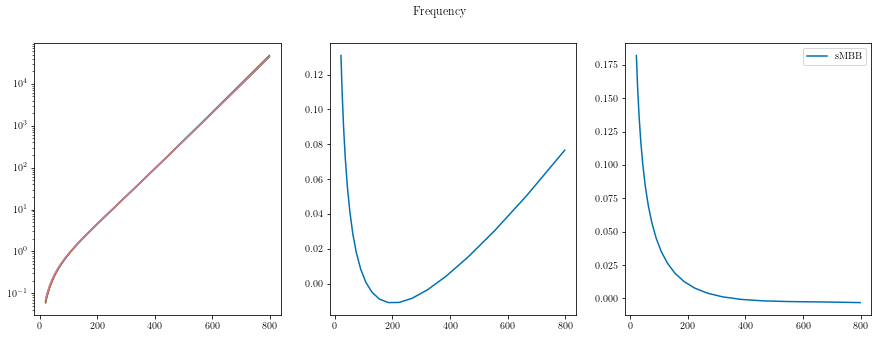

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

ax1.semilogy(nu_pico / 1e9, make_signal([sMBB])[1], label='sMBB')
ax1.semilogy(nu_pico / 1e9, make_signal([TMFM])[1], label='TMFM')
ax1.semilogy(nu_pico / 1e9, make_signal([sMBB])[2], label='sMBB')
ax1.semilogy(nu_pico / 1e9, make_signal([TMFM])[2], label='TMFM')

ax2.plot(nu_pico / 1e9, (make_signal([TMFM])[1] - make_signal([sMBB])[1])
             / make_signal([sMBB])[1], label='sMBB')

ax3.plot(nu_pico / 1e9, (make_signal([TMFM])[2] - make_signal([sMBB])[2])
             / make_signal([sMBB])[2], label='sMBB')


#plt.xlim(nu_pico[0] / 1e9, nu_pico[-1] / 1e9)
#plt.ylim(-.02, .12)

plt.suptitle('Frequency', fontsize=12)
#plt.ylabel('Fractional difference', fontsize=12)
plt.legend()


In [10]:
fsigma_T=1e5
fsigma_P=1.

beam_mat = np.identity(3*len(nu_pico)) # Beam model

params_sMBB = [sMBB.amp_I, sMBB.amp_Q, sMBB.amp_U, cmb.amp_I, cmb.amp_Q, cmb.amp_U,
              sync.amp_I, sync.amp_Q, sync.amp_U, sMBB.dust_beta, sMBB.dust_T,
              sync.sync_beta]

initial_vals_sMBB = (amp_I, amp_Q, amp_U, cmb.amp_I, cmb.amp_Q, cmb.amp_U,
                    sync.amp_I, sync.amp_Q, sync.amp_U, mean_beta, mean_temp,
                    sync.sync_beta)

In [11]:
runs = 20
runs_sMBB = [None] * runs
runs_TMFM = [None] * runs

sMBB_data = [None] * runs
TMFM_data = [None] * runs

parent_model = 'mbb'

for i in range(runs):
    
    print ('now on run: ', i)
    
    D_vec_sMBB, Ninv_sMBB = fitting.generate_data(nu_pico, fsigma_T, fsigma_P,
                                            [sMBB, cmb, sync],
                                            noise_file="data/noise_pico.dat" )

    D_vec_TMFM, Ninv_TMFM = fitting.generate_data(nu_pico, fsigma_T, fsigma_P,
                                            [TMFM, cmb, sync],
                                            noise_file="data/noise_pico.dat")
    
    sMBB_data[i] = D_vec_sMBB
    TMFM_data[i] = D_vec_TMFM


    data_spec_sMBB = (nu_pico, D_vec_sMBB, Ninv_sMBB, beam_mat)
    data_spec_TMFM = (nu_pico, D_vec_TMFM, Ninv_TMFM, beam_mat)

    p_spec_sMBB = (pnames_sMBB, initial_vals_sMBB, parent_model)
   
    runs_sMBB[i]  = fitting.joint_mcmc(data_spec_sMBB,
                                                [sMBB, cmb, sync],
                                                p_spec_sMBB, nwalkers=24,
                                                burn=1000, steps=10000, nthreads=1,
                                                sample_file=None)
    

    runs_TMFM[i]  = fitting.joint_mcmc(data_spec_TMFM,
                                                [sMBB, cmb, sync],
                                                p_spec_sMBB, nwalkers=24,
                                                burn=1000, steps=10000, nthreads=1,
                                                sample_file=None)
    

now on run:  0
now on run:  1
now on run:  2
now on run:  3
now on run:  4
now on run:  5
now on run:  6
now on run:  7
now on run:  8
now on run:  9
now on run:  10
now on run:  11
now on run:  12
now on run:  13
now on run:  14
now on run:  15
now on run:  16
now on run:  17
now on run:  18
now on run:  19


In [12]:
sMBB_logp_max = [None] * runs
sMBB_best_fits = [None] * runs

for i in range(runs):
    sMBB_logp_max[i] = runs_sMBB[i][2].max()
    sMBB_best_fits[i] = [runs_sMBB[i][1][j][runs_sMBB[i][2].argmax()] for j in range(len(pnames_sMBB))]
    
TMFM_logp_max = [None] * runs
TMFM_best_fits = [None] * runs

for i in range(runs):
    TMFM_logp_max[i] = runs_TMFM[i][2].max()
    TMFM_best_fits[i] =[runs_TMFM[i][1][j][runs_sMBB[i][2].argmax()] for j in range(len(pnames_sMBB))]


In [13]:
sMBB_lnprob = np.zeros(runs)
TMFM_lnprob = np.zeros(runs)

for i in range(runs):
    sMBB_lnprob[i] = fitting.lnprob_joint(sMBB_best_fits[i], (nu_pico, sMBB_data[i], Ninv_sMBB, beam_mat),
                 models_sMBB, p_spec_sMBB)
    TMFM_lnprob[i] = fitting.lnprob_joint(TMFM_best_fits[i], (nu_pico, TMFM_data[i], Ninv_sMBB, beam_mat),
                 models_sMBB, p_spec_sMBB)
    

In [14]:
def chi_square(nu, models_fit, params, data, noise):
    Nmod = len(models_fit)
    Npol = 3

    # Separate amplitude and spectral model parameters
    amps = params[:Nmod*Npol]
    #print(amps)
    pvals = params[Nmod*Npol:]
    #print(pvals)

    # Create new copies of model objects to work with
    #models = [copy.deepcopy(m) for m in models_fit]
    models = models_fit

    # Set new parameter values for the copied model objects, and then get
    # scalings as a function of freq./polarisation
    pstart = 0
    mdata = np.zeros(nu.size * Npol)
    ddata = np.asarray(data)
    
    for i in range(len(models)):
        m = models[i]

        # Set new parameter values in the models
        n = m.params().size
        #m.set_params( pvals[pstart:pstart+n] )
        mparams = pvals[pstart:pstart+n]
        pstart += n # Increment for next model

        # Calculate scaling with freq. given new parameter values
        amp = np.outer( amps[3*i:3*(i+1)], np.ones(nu.size) ) # Npol*Nfreq array
        #print(amp)

        # Add to model prediction of data vector
        mdata += (amp * m.scaling(nu, params=mparams)).flatten()
    
    chi_squares = np.zeros(nu.size)    
    for j in range(nu.size):
        mdata_per_nu = np.matrix(mdata[j:nu.size*Npol:nu.size]).T
        ddata_per_nu = np.matrix(ddata[j:nu.size*Npol:nu.size])
        Ninv = np.diag(noise)[j] * np.identity(3)
        
        chi_squares[j] = (ddata_per_nu - mdata_per_nu).T * Ninv * (ddata_per_nu - mdata_per_nu)
        
    # Calculate chi-squared with data (assumed beam = 1)
    
    #chi_square = (D_vec - mdata).T * Ninv * (D_vec - mdata)

    # Return log-posterior
    #return logpr - 0.5 * chi_square
    return -0.5 * chi_squares
 

In [15]:
fitting.lnprob_joint(TMFM_best_fits[0], (nu_pico, TMFM_data[0], Ninv_sMBB, beam_mat),
                 models_sMBB, p_spec_sMBB)

matrix([[-5168.76642269]])

Text(0.5, 0, 'log frequency')

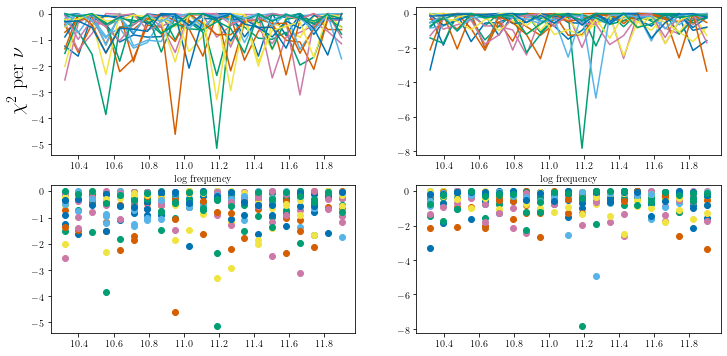

In [31]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(12,6))

for i in range(runs):
    ax1.plot(np.log10(nu_pico), chi_square(nu_pico, models_sMBB, sMBB_best_fits[i],
                       sMBB_data[i], Ninv_sMBB))

    ax2.plot(np.log10(nu_pico), chi_square(nu_pico, models_sMBB, TMFM_best_fits[i],
                       TMFM_data[i], Ninv_TMFM))
    
    ax3.plot(np.log10(nu_pico), chi_square(nu_pico, models_sMBB, sMBB_best_fits[i],
                       sMBB_data[i], Ninv_sMBB), ls='', marker='o')

    ax4.plot(np.log10(nu_pico), chi_square(nu_pico, models_sMBB, TMFM_best_fits[i],
                       TMFM_data[i], Ninv_TMFM), ls='', marker='o')
    
    
ax1.set_ylabel(r'$\chi^2$ per $\nu$', fontsize=20)
ax1.set_xlabel('log frequency')
ax2.set_xlabel('log frequency')